# Angelo Rossi (u18141529) --- Critical evaluation on the control ofa self-preheating CSTR
CPB410 Assignment Part 1

In [ ]:
import numpy
import scipy
import scipy.optimize
import scipy.integrate
import matplotlib as mpl
import matplotlib.pyplot as plt
import tbcontrol.responses
import control
import pandas as pd
from collections import deque
%matplotlib inline

mpl.rcParams['font.serif'] ="Cambria"
mpl.rcParams['font.family'] ="serif"
mpl.rcParams['font.size']="22"

#plt.rc('text', usetex=True )
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

# System description and diagram

![Exercise_2-6_diagram.svg](Exercise_2-6_diagram.svg)

A closed stirred-tank reactor with two compartments is shown above. The basic idea is to feed the reactants continuously into the first compartment, where they will be preheated by energy liberated in the exothermic reaction,which is anticipated to occur primarily in the second compartment. The wall separating the two compartments is quite thin, thus allowing heat transfer; the outside of the reactor is well insulated; and a cooling coil is built into the second compartment to remove excess energy liberated in the reaction. Both tanks are completely full at all times.Tests are to be conducted initially with a single-component feed (i.e., no reaction) to evaluate the reactor’s thermal characteristics. The system is quite sensitive to changes in inlet temperature. The inlet volumetric flowrate will be manipulated whilst changes in inlet temperature Ti are expected to be disturbances to the system. The goal of the implemented control algorithm will be to control the outlet concentration c$_{A2}$.

# Model equations 

The following modelling equations were used to simulate the above mentioned system. It is assumed that there is no mass acumulation in the tanks and that heat capacity is not a function of temperature. In addition it is assumed that the heat carrying capcacity of the reactants is approximately equivalent to that of the products.

## Model
\begin{align}
q_{0}(t) &= q_{1}(t) = q_{2}(t) \\
c_{A0}(t) &= c_{A1}(t) \\
V_{1}\rho C \frac{\mathrm{d}T_{1}}{\mathrm{d}t} &= \rho q C (T_{i}-T_{1}) + UA(T_{1}-T_{2}) \\
k &= k_{0}\exp\left(\frac{-E}{RT}\right)\\
\frac{\mathrm{d}c_{A2}}{\mathrm{d}t} &= \frac{q}{V_{2}}(c_{A1}-c_{A2}) - kc_{A2} \\
V_{2}\rho C \frac{\mathrm{d}T_{1}}{\mathrm{d}t} &= \rho q C (T_{1}-T_{2}) - \Delta H_{r}V_{2}kc_{A2} + UA(T_{1}-T_{2}) - U_{c}A_{c}(T_{2}-T_{c}) \\
\end{align}

# Parameters

In [210]:
cA0 = 1  # mol/L
V1 = V2 = V  = 1000  # L
ρ = 500 # g/L
C = 0.239 # J/(g K)
Hr = -1e4  # J/(g K)
E_over_R = 8500  # K
k0 = 4e10  # 1/min
UA = 0.1e4  # J/(min K)
UcAc = 0.3e4 #J/(min K)
Tc = 298.15 #K

# Inputs

In [211]:
def MV_q0(t): #this is your manipulated variable
    
    if t<0: 
        return 55
    
    if t>=0:
        return 55
    
def DV_Ti(t): #this is your disturbance variable 
    
    if t<0: 
        return 298.15
    
    if t>=0:
        return 298.15



# Model equations

In [212]:
def intsys(t, x):
    
    T1, cA2, T2 = x
    
    
    q = MV_q0(t)
    
    cA1 = cA0
    
    dT1dt = 1/(V1*ρ*C)*(ρ*q*C*(DV_Ti(t) - T1) + UA*(T1 - T2))
    
    k = k0*numpy.exp(-E_over_R/T2)
    
    dcA2dt = q*(cA1 - cA2)/V - k*cA2
    
    dT2dt = 1/(V2*ρ*C)*(ρ*q*C*(T1 - T2) - Hr*V2*k*cA2 + UA*(T1 - T2)-UcAc*(T2-Tc))
    
    
    return [dT1dt,dcA2dt,dT2dt]

# Time range and step size 

In [213]:
tspan = (0, 100)
t = numpy.linspace(*tspan, 1000)


Now we will make sure the system is at steady state 

In [214]:
x0 = [290,340,0.1]

def ss(x):
    
    return intsys(0,x)

x0 = scipy.optimize.fsolve(ss,x0)

ss(x0)

[7.306400951481264e-16, -2.0816681711721685e-17, 4.870933967654176e-16]

Seems pretty good to me, now lets simulate

# Simulation function

In [215]:
def simulate():
    r = scipy.integrate.solve_ivp(intsys, tspan, x0, t_eval=t, max_step=0.1)
    return r.y

# Plot

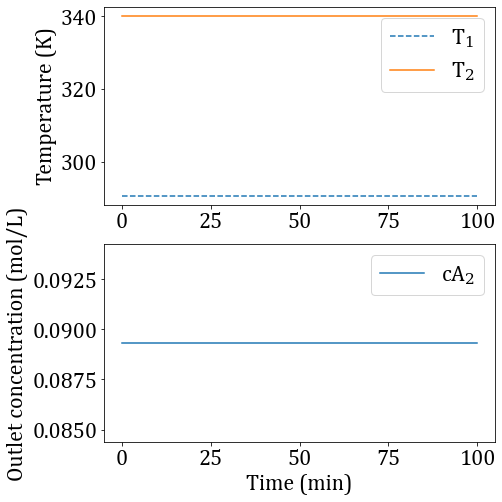

In [216]:
fig,[axT,axcA] = plt.subplots(2,1,figsize = (7,8))

T1,cA2,T2 = simulate()
axT.plot(t,T1, label = 'T$_{1}$',linestyle = '--')
axT.plot(t,T2, label = 'T$_{2}$')
axT.legend()
axT.set_ylabel('Temperature (K)')
axcA.plot(t,cA2, label = 'cA$_{2}$')
plt.xlabel('Time (min)')
axcA.set_ylabel('Outlet concentration (mol/L)')
plt.legend()
plt.show()

That outlet concentration looks a little strange, notice the multiplier at the top of axcA.

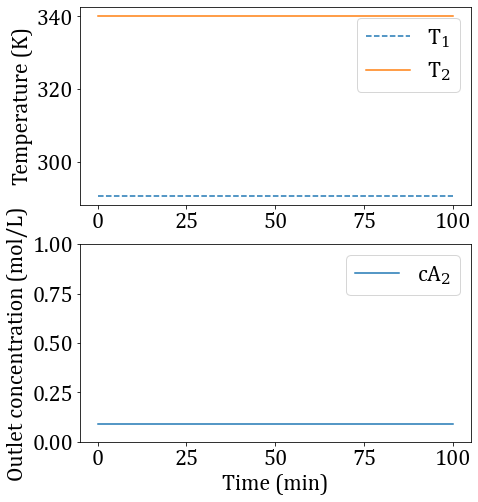

In [217]:
fig,[axT,axcA] = plt.subplots(2,1,figsize = (7,8))

T1,cA2,T2 = simulate()
axT.plot(t,T1, label = 'T$_{1}$',linestyle = '--')
axT.plot(t,T2, label = 'T$_{2}$')
axT.legend()
axT.set_ylabel('Temperature (K)')
axcA.plot(t,cA2, label = 'cA$_{2}$')
plt.xlabel('Time (min)')
axcA.set_ylabel('Outlet concentration (mol/L)')
plt.ylim([0,1])
plt.legend()
plt.show()

Perfect ! Have fun !

In [221]:
T1_ss, cA2_ss, T2_ss = x0
T1_ss, cA2_ss, T2_ss

(290.6165644675511, 0.08930686289718223, 340.13006950457134)

# Implementation

## Step size in solver
Investigating the effect on the solver step size to yield a better simulation result

In [222]:
M = 0.05*55
M

2.75

In [223]:
def MV_q0(t): #this is your manipulated variable
    
    if t<0: 
        return 55
    
    if t>=0:
        return 55 + M
    
def DV_Ti(t): #this is your disturbance variable 
    
    if t<0: 
        return 298.15
    
    if t>=0:
        return 298.15
    
tspan = (0, 100)
t = numpy.linspace(*tspan, 1000)

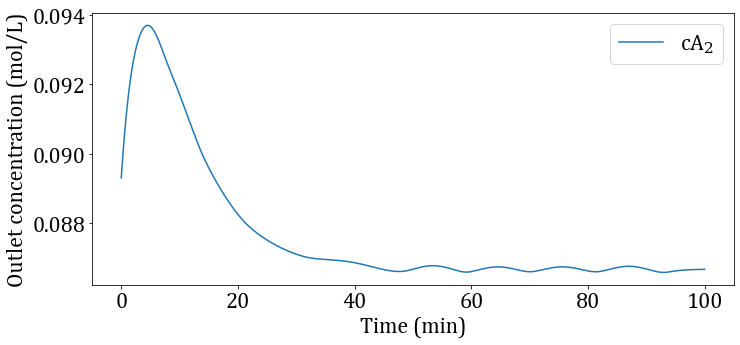

In [224]:
def simulate():
    r = scipy.integrate.solve_ivp(intsys, tspan, x0, t_eval=t)
    return r.y
T1,cA2,T2 = simulate()

fig,axcA = plt.subplots(1,1,figsize = (23/2, 5))
axcA.plot(t,cA2, label = 'cA$_{2}$')
axcA.set_xlabel('Time (min)')
axcA.set_ylabel('Outlet concentration (mol/L)')
plt.legend()
#plt.savefig('5_step_change.svg')
plt.show()

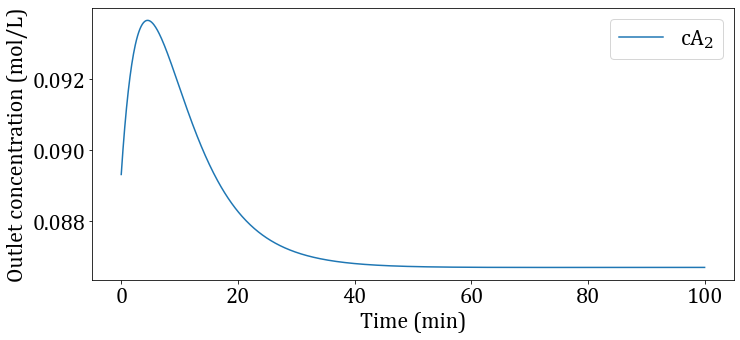

In [225]:
def simulate():
    r = scipy.integrate.solve_ivp(intsys, tspan, x0, t_eval=t, max_step=0.1) # with the new overriden max step
    return r.y
T1_ms,cA2_ms,T2_ms = simulate()

fig,axcA = plt.subplots(1,1,figsize = (23/2, 5))
axcA.plot(t,cA2_ms, label = 'cA$_{2}$')
axcA.set_xlabel('Time (min)')
axcA.set_ylabel('Outlet concentration (mol/L)')
plt.legend()
#plt.savefig('5_step_change_ms.svg')
plt.show()

## Fit model with curve_fit
Fitting response to a 10 % step in the disturbance

In [226]:
M = 0.1*55
M

5.5

In [227]:
def MV_q0(t): #this is your manipulated variable
    
    if t<0: 
        return 55
    
    if t>=0:
        return 55 + M
    
def DV_Ti(t): #this is your disturbance variable 
    
    if t<0: 
        return 298.15
    
    if t>=0:
        return 298.15

In [228]:
tspan = (0, 100)
t = numpy.linspace(*tspan, 1000)

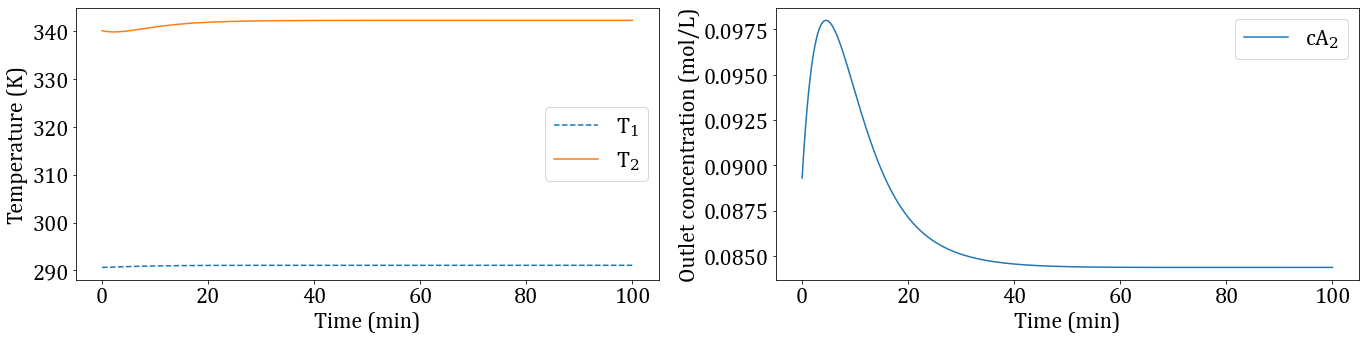

In [229]:
fig,[axT,axcA] = plt.subplots(1,2,figsize = (23, 5))

T1,cA2,T2 = simulate()
axT.plot(t,T1, label = 'T$_{1}$',linestyle = '--')
axT.plot(t,T2, label = 'T$_{2}$')
axT.set_xlabel('Time (min)')
axT.legend()
axT.set_ylabel('Temperature (K)')
axcA.plot(t,cA2, label = 'cA$_{2}$')
axcA.set_xlabel('Time (min)')
axcA.set_ylabel('Outlet concentration (mol/L)')
plt.legend()
#plt.savefig('minus10_step_change.svg')
plt.show()

In [230]:
K_guess = -0.0007
τ_guess = 9
θ_guess = 15

cA2_guess = tbcontrol.responses.fopdt(t, M*K_guess, τ_guess, θ_guess) + cA2_ss

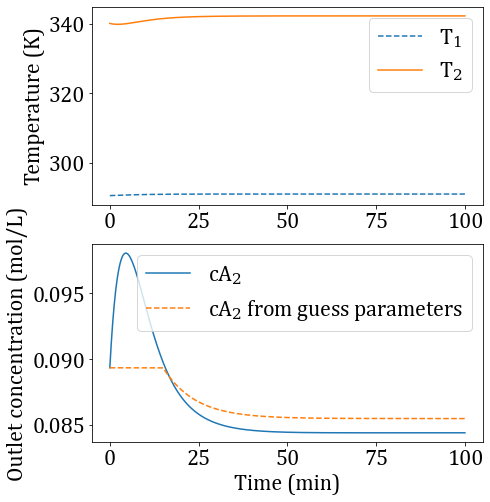

In [231]:
fig,[axT,axcA] = plt.subplots(2,1,figsize = (7,8))

T1,cA2,T2 = simulate()
axT.plot(t,T1, label = 'T$_{1}$',linestyle = '--')
axT.plot(t,T2, label = 'T$_{2}$')
axT.legend()
axT.set_ylabel('Temperature (K)')
axcA.plot(t,cA2, label = 'cA$_{2}$')
axcA.plot(t, cA2_guess, linestyle='--', label='cA$_{2}$ from guess parameters')
plt.xlabel('Time (min)')
axcA.set_ylabel('Outlet concentration (mol/L)')
plt.legend()
plt.show()

In [232]:
KM_10fit, τ_10fit, θ_10fit = scipy.optimize.curve_fit(tbcontrol.responses.fopdt, t, cA2 - cA2_ss, [M*K_guess, τ_guess, θ_guess])[0]
K_10fit = KM_10fit/M
cA2_10fit = tbcontrol.responses.fopdt(t, KM_10fit, τ_10fit, θ_10fit) + cA2_ss

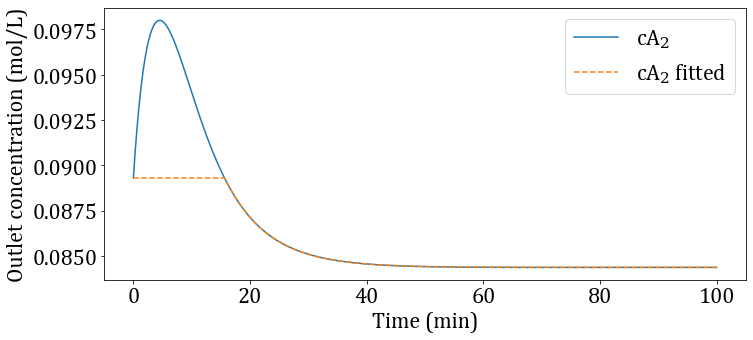

K: -0.000896782257112655, τ: 7.500367649927909, θ: 15.651229900390387


In [233]:
fig, axcA = plt.subplots(1,1,figsize = (23/2, 5))

T1,cA2,T2 = simulate()
axcA.plot(t,cA2, label = 'cA$_{2}$')
axcA.plot(t, cA2_10fit, linestyle='--', label='cA$_{2}$ fitted')
plt.xlabel('Time (min)')
axcA.set_ylabel('Outlet concentration (mol/L)')
plt.legend()
#plt.savefig('10_fit.svg')
plt.show()

print(f'K: {K_10fit}, τ: {τ_10fit}, θ: {θ_10fit}')

## Applying step disturbances of various magnitudes from -30 % to 30 % in 1 % intervals
Investigating the effect of non-linearity on the system by fitting FOPDT models to varying step changes

In [234]:
perc_list = numpy.arange(-30, 30 + 1, 1)
perc_list = [perc for perc in perc_list if (perc != 0)]
M_list = [perc/100*55 for perc in perc_list]

In [235]:
def MV_q0(t): #this is your manipulated variable
    
    if t<0: 
        return 55
    
    if t>=0:
        return 55 + M
    
def DV_Ti(t): #this is your disturbance variable 
    
    if t<0: 
        return 298.15
    
    if t>=0:
        return 298.15

In [236]:
τ_guess = 9
θ_guess = 15
K_guess = -0.001

tspan = (0, 100)
t = numpy.linspace(*tspan, 2000)

KM_list = []
τ_list = []
θ_list = []
for M in M_list:
    T1,cA2,T2 = simulate()
    KM_fit, τ_fit, θ_fit = scipy.optimize.curve_fit(tbcontrol.responses.fopdt, t, cA2 - cA2_ss, [M*K_guess, τ_guess, θ_guess])[0]
    KM_list.append(KM_fit)
    τ_list.append(τ_fit)
    θ_list.append(θ_fit)
results_df = pd.DataFrame(columns=['% step', 'M', 'K', 'τ', 'θ'])
results_df['% step'] = numpy.array(M_list)/55*100
results_df['M'] = M_list
results_df['K'] = numpy.array(KM_list)/numpy.array(M_list)
results_df['τ'] = τ_list
results_df['θ'] = θ_list
results_df.set_index('% step', inplace=True)
display(results_df)

,M,K,τ,θ
% step,,,,
-30.0,-16.50,-0.001556,9.812109,20.239635
-29.0,-15.95,-0.001530,9.743086,20.056760
-28.0,-15.40,-0.001506,9.662879,19.890924
-27.0,-14.85,-0.001482,9.585348,19.728337
-26.0,-14.30,-0.001459,9.524534,19.555964
-25.0,-13.75,-0.001436,9.452624,19.399557
-24.0,-13.20,-0.001414,9.383047,19.246158
-23.0,-12.65,-0.001392,9.315396,19.095829
-22.0,-12.10,-0.001371,9.250043,18.948307


Text(0.5, 0, '% step')

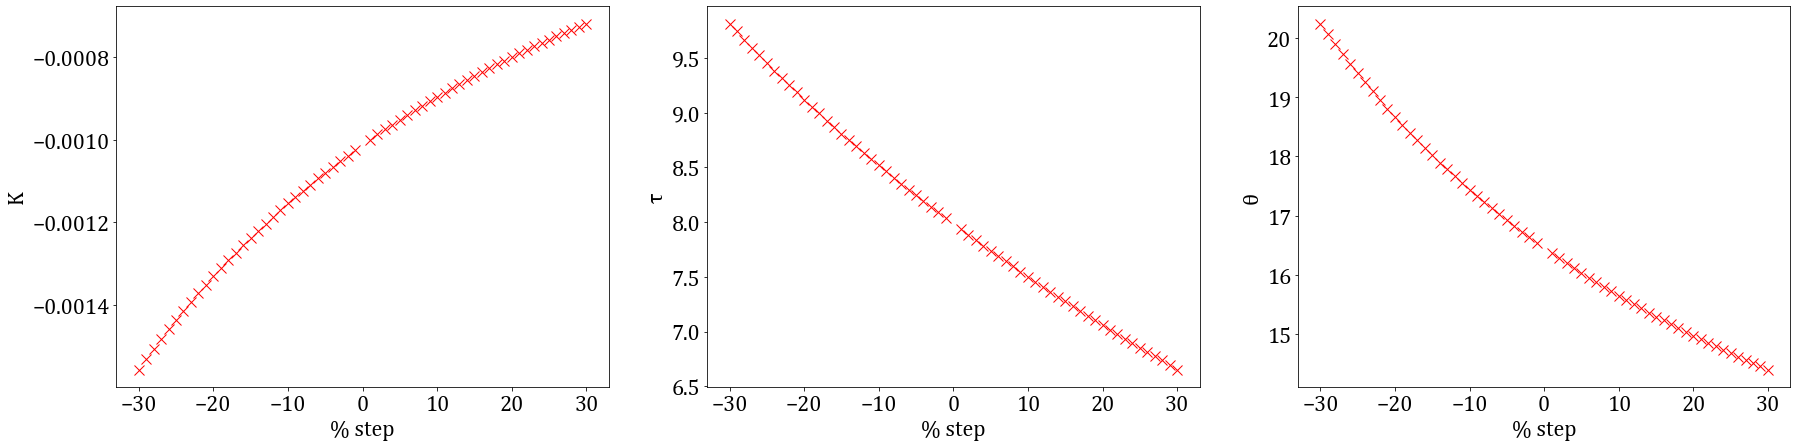

In [237]:
fig = plt.figure(figsize = (30, 7))
axK = fig.add_subplot(131)
axK.plot(perc_list, numpy.array(KM_list)/numpy.array(M_list), 'rx', markersize=10)
axK.set_ylabel('K')
axK.set_xlabel('% step')
axτ = fig.add_subplot(132)
axτ.plot(perc_list, τ_list, 'rx', markersize=10)
axτ.set_ylabel('τ')
axτ.set_xlabel('% step')
axθ = fig.add_subplot(133)
axθ.plot(perc_list, θ_list, 'rx', markersize=10)
axθ.set_ylabel('θ')
axθ.set_xlabel('% step')
#plt.savefig('various_fit.svg')

## Fitting around a different steady state point
Investigating the effect of the point of linearisation by fitting around a new steady state point

In [238]:
ss_factor = 0.1
M = 5.5

In [239]:
def MV_q0(t): #this is your manipulated variable
    
    if t<0: 
        return 55
    
    elif (t >= 0) and (t <= 100):
        return (1 + ss_factor)*55
    
    elif (t >= 100):
        return (1 + ss_factor)*55 + M
    
def DV_Ti(t): #this is your disturbance variable 
    
    if t<0: 
        return 298.15
    
    elif (t >= 0):
        return 298.15

In [240]:
tspan = (0, 200)
t = numpy.linspace(*tspan, 3000)

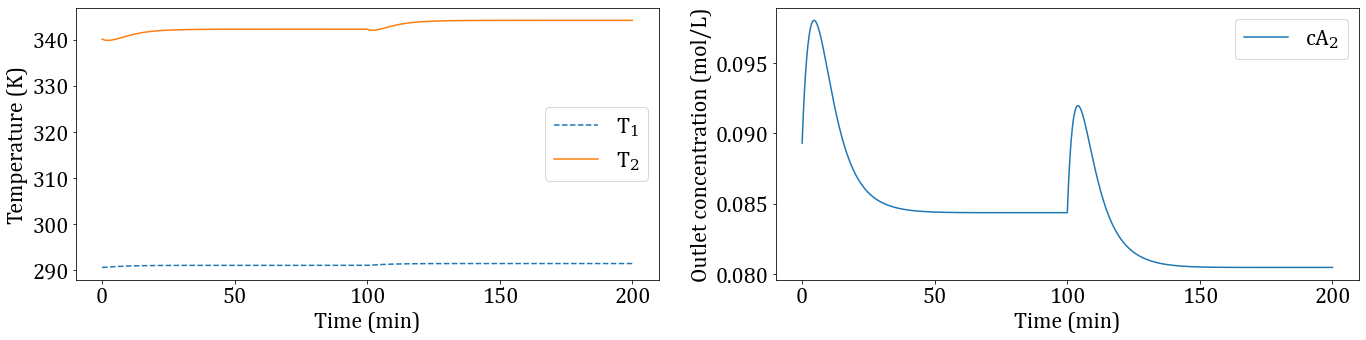

In [241]:
fig,[axT,axcA] = plt.subplots(1,2,figsize = (23, 5))

T1,cA2,T2 = simulate()
axT.plot(t,T1, label = 'T$_{1}$',linestyle = '--')
axT.plot(t,T2, label = 'T$_{2}$')
axT.set_xlabel('Time (min)')
axT.legend()
axT.set_ylabel('Temperature (K)')
axcA.plot(t,cA2, label = 'cA$_{2}$')
axcA.set_xlabel('Time (min)')
axcA.set_ylabel('Outlet concentration (mol/L)')
plt.legend()
#plt.savefig('10_ss_and_5.5_step_change.svg')
plt.show()

In [243]:
i_sc = numpy.where(t >= 100)[0]
i_newss = i_sc[0]

t_sc = numpy.linspace(0, 100, len(i_sc))
cA2_sc = cA2[i_sc]
cA2_newss = cA2[i_newss]
t_sc, cA2_newss, cA2_sc # new steady state

(array([0.00000000e+00, 6.67111408e-02, 1.33422282e-01, ...,
        9.98665777e+01, 9.99332889e+01, 1.00000000e+02]),
 0.0844877640234502,
 array([0.08448776, 0.08482666, 0.08514229, ..., 0.0804989 , 0.0804989 ,
        0.0804989 ]))

In [244]:
KM_ssfit, τ_ssfit, θ_ssfit = scipy.optimize.curve_fit(tbcontrol.responses.fopdt, t_sc, cA2_sc - cA2_newss, [M*K_guess, τ_guess, θ_guess])[0]
cA2_ssfit = tbcontrol.responses.fopdt(t_sc, KM_ssfit, τ_ssfit, θ_ssfit) + cA2_newss

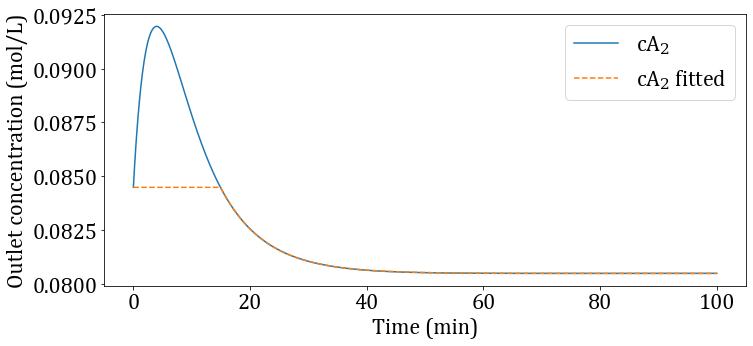

K: -0.0007261401523394259, τ: 7.685253916268478, θ: 14.931755995617818


In [245]:
fig, axcA = plt.subplots(1,1,figsize = (23/2, 5))

axcA.plot(t_sc,cA2_sc, label = 'cA$_{2}$')
axcA.plot(t_sc, cA2_ssfit, linestyle='--', label='cA$_{2}$ fitted')
plt.xlabel('Time (min)')
axcA.set_ylabel('Outlet concentration (mol/L)')
plt.legend()
#plt.savefig('5.5_ss_fit.svg')
plt.show()

print(f'K: {KM_ssfit/M}, τ: {τ_ssfit}, θ: {θ_ssfit}')

## Implementation of a controller

### Cohen-Coon controller integration

In [246]:
Φ = θ_10fit/τ_10fit

# P controller
Kc_p = (Φ + 3)/(3*K_10fit*Φ)

# PI controller
Kc_pi = (5*Φ + 54)/(60*K_10fit*Φ)
τi_pi = θ_10fit*(30 + 3*Φ)/(9 + 20*Φ)

# PID controller
Kc_pid = (3*Φ + 16)/(12*K_10fit*Φ)
τi_pid = θ_10fit*(32 + 6*Φ)/(13 + 8*Φ)
τd_pid = 4*θ_10fit/(11 + 2*Φ)

print(Kc_p, Kc_pi, Kc_pid)
print(τi_pi, τi_pid)
print(τd_pid)

-906.0754546848407 -573.8633670343308 -991.2760171087388
11.185992586285177 23.46610799795862
4.125949725265595


In [247]:
M_d = 0.02*298.15
M_sp = 0.1*cA2_ss

In [248]:
def DV_Ti(t): #this is your disturbance variable 
    if t<0: 
        return 298.15
    elif (t >= 0):
        return 298.15

def SP_cA2(t): # set point
    if (t < 0):
        return cA2_ss
    if (t >= 0):
        return cA2_ss + M_sp
    
# continous form
def q_controller(cont_id, dt, q, e_hist, ei, ei1):  # <--- deals with the controller outputs/controller equations
    if (cont_id == None):
        p = 55
    elif (cont_id == 'P'):
        p = 55 + Kc_p*ei
    elif (cont_id == 'PI'):
        p = 55 + Kc_pi*(ei + 1/τi_pi*e_hist*dt)
    elif (cont_id == 'PID'):
        p = 55 + Kc_pid*(ei + 1/τi_pid*e_hist*dt + τd_pid*(ei - ei1)/dt)
        
    # saturation
    if (p < 0):
        p = 0
    if (p > 2*55):
        p = 2*55
    return p

def euler_simulate_with_controller(tspan, initial, cont_id=None): # <--- euler loop for controller simulation (cont_id is the type of controller, 'P'/'PI'/'PID').
    dt = tspan[1]
    T1, cA2, T2, q = initial
    q = 55
    T1_list, cA2_list, T2_list, q_list = [T1], [cA2], [T2], [q]
    e_hist = 0
    ei = 0
    ei1 = 0
    for i, t in enumerate(tspan):
        if (i != 0):
            # error and controller
            ei1 = ei
            ei = SP_cA2(t) - cA2
            if (q != 0) or (q != 2*55): # anti-reset windup
                e_hist += ei
            q = q_controller(cont_id, dt, q, e_hist, ei, ei1)
            
            # the remainder of the system
            cA1 = cA0
            k = k0*numpy.exp(-E_over_R/T2)

            dT1dt = 1/(V1*ρ*C)*(ρ*q*C*(DV_Ti(t) - T1) + UA*(T1 - T2))
            dcA2dt = q*(cA1 - cA2)/V - k*cA2
            dT2dt = 1/(V2*ρ*C)*(ρ*q*C*(T1 - T2) - Hr*V2*k*cA2 + UA*(T1 - T2)-UcAc*(T2-Tc))
            T1 = T1 + dT1dt*dt
            T2 = T2 + dT2dt*dt
            cA2 = cA2 + dcA2dt*dt

            T1_list.append(T1)
            T2_list.append(T2)
            cA2_list.append(cA2)
            q_list.append(q)   
    return T1_list, cA2_list, T2_list, q_list

In [249]:
def sim_closed_loop(filename_tc, filename_q): # simulates and plots responses to all three controllers using the euler_simulate_with_controller function
    tspan = (0, 500)
    t = numpy.linspace(*tspan, int(5e4))
    initial = numpy.append(numpy.array(x0), numpy.array(55))

    T1_p, cA2_p, T2_p, q_p = euler_simulate_with_controller(t, initial, 'P')
    T1_pi, cA2_pi, T2_pi, q_pi = euler_simulate_with_controller(t, initial, 'PI')
    T1_pid, cA2_pid, T2_pid, q_pid = euler_simulate_with_controller(t, initial, 'PID')
    T1, cA2, T2, q = euler_simulate_with_controller(t, initial)
    fig, [axT,axcA] = plt.subplots(1,2,figsize = (23, 10))

    # temperature
    axT.plot(t,T1, label = 'T$_{1}$ (no controller)',linestyle = '--')
    axT.plot(t,T1_p, 'r', label = 'T$_{1}$ (P controller)',linestyle = '--')
    axT.plot(t,T1_pi, 'g', label = 'T$_{1}$ (PI controller)',linestyle = '--')
    axT.plot(t,T1_pid, 'purple', label = 'T$_{1}$ (PID controller)',linestyle = '--')

    axT.plot(t,T2, label = 'T$_{2}$ (no controller)')
    axT.plot(t,T2_p, 'r', label = 'T$_{2}$ (P controller)')
    axT.plot(t,T2_pi, 'g', label = 'T$_{2}$ (PI controller)')
    axT.plot(t,T2_pid, 'purple', label = 'T$_{2}$ (PID controller)')

    axT.set_xlabel('Time (min)')
    axT.set_ylabel('Temperature (K)')
    axT.legend()

    # concentration
    axcA.plot(t, list(map(SP_cA2, t)), 'k', linestyle='--', label='Set point')
    axcA.plot(t,cA2, label = 'cA$_{2}$ (no controller)')
    axcA.plot(t,cA2_p, 'r', label = 'cA$_{2}$ (P controller)')
    axcA.plot(t,cA2_pi, 'g', label = 'cA$_{2}$ (PI controller)')
    axcA.plot(t,cA2_pid, 'purple', label = 'cA$_{2}$ (PID controller)')

    axcA.set_xlabel('Time (min)')
    axcA.set_ylabel('Outlet concentration (mol/L)')
    axcA.legend()

    #plt.savefig(filename_tc)
    plt.show()
    
    fig, axQ = plt.subplots(1,1,figsize = (23/2, 5))

    # q
    axQ.plot(t, q, label='q (no controller)')
    axQ.plot(t, q_p, label='q (P controller)')
    axQ.plot(t, q_pi, label='q (PI controller)')
    axQ.plot(t, q_pid, label='q (PID controller)')

    axQ.set_xlabel('Time (min)')
    axQ.set_ylabel('Volumetric flowrate (L/min)')
    axQ.legend()
    #plt.savefig(filename_q)

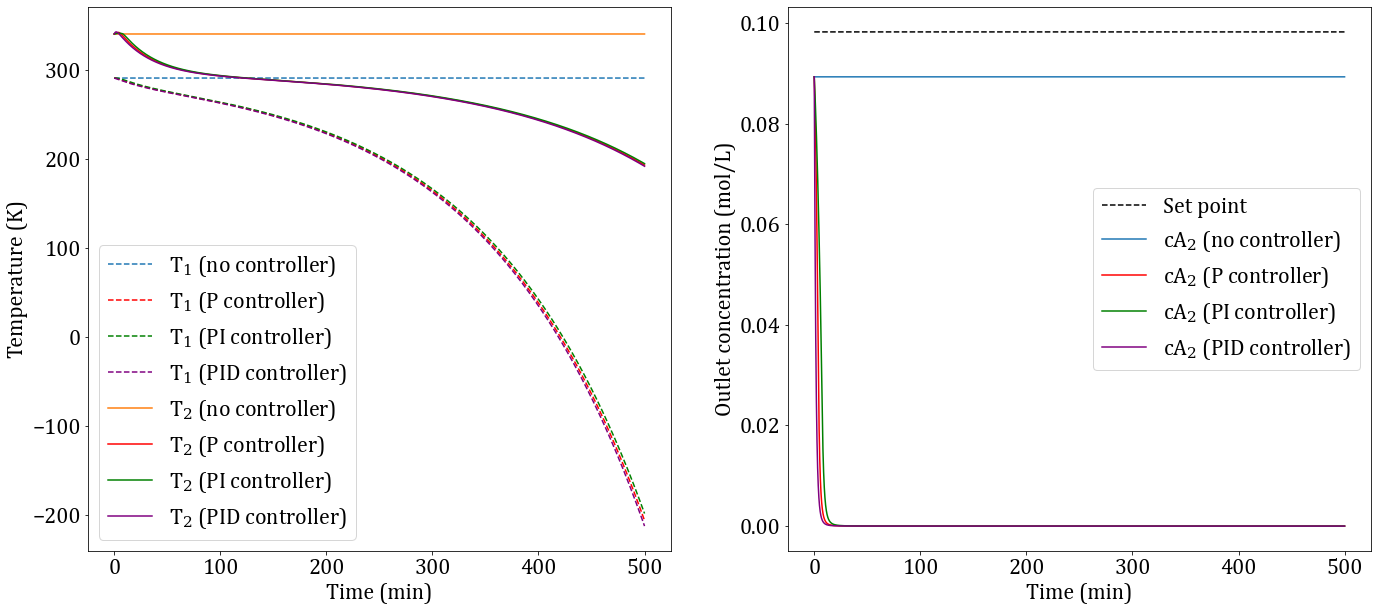

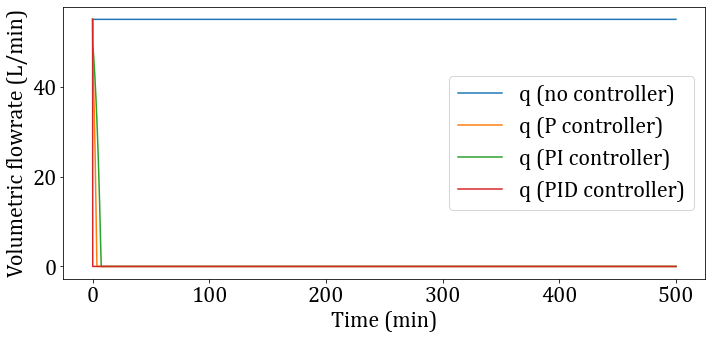

In [250]:
sim_closed_loop('2_sp_tc_cc.svg', '2_sp_q_cc.svg')

### IMC controller intregration
For better controller parameters, the model was fitted to a two-pole-right-hand-plane-zero model and the IMC controller parameters were calculated for a PID controller

#### Fit to two-pole-right-hand-plane-zero model

In [251]:
M = 0.1*55

def MV_q0(t): #this is your manipulated variable
    
    if t<0: 
        return 55
    
    if t>=0:
        return 55 + M
    
def DV_Ti(t): #this is your disturbance variable 
    
    if t<0: 
        return 298.15
    
    if t>=0:
        return 298.15
    
def second_order_pole(t, K, τ, β, ζ):
    s = control.tf([1, 0], [1])
    G = K*(-β*s + 1)/(τ**2*s**2 + 2*τ*ζ*s + 1)
    cA2 = M*control.step_response(G, t)[1] + cA2_ss
    return cA2

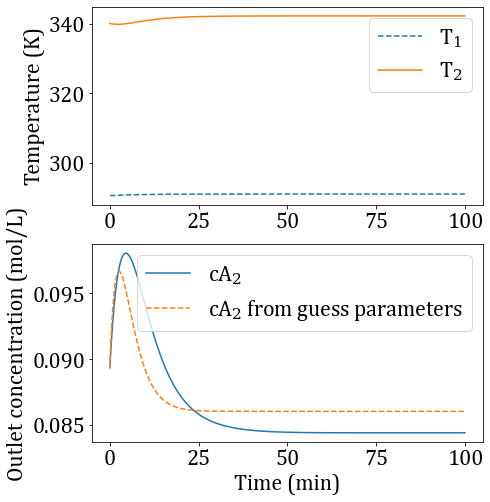

In [252]:
tspan = (0, 100)
t = numpy.linspace(*tspan, 1000)

K_guess = -0.0006
τ_guess = 3
β_guess = 20
ζ_guess = 1


cA2_guess = second_order_pole(t, K_guess, τ_guess, β_guess, ζ_guess)
fig,[axT,axcA] = plt.subplots(2,1,figsize = (7,8))

T1,cA2,T2 = simulate()
axT.plot(t,T1, label = 'T$_{1}$',linestyle = '--')
axT.plot(t,T2, label = 'T$_{2}$')
axT.legend()
axT.set_ylabel('Temperature (K)')
axcA.plot(t,cA2, label = 'cA$_{2}$')
axcA.plot(t, cA2_guess, linestyle='--', label='cA$_{2}$ from guess parameters')
plt.xlabel('Time (min)')
axcA.set_ylabel('Outlet concentration (mol/L)')
plt.legend()
plt.show()

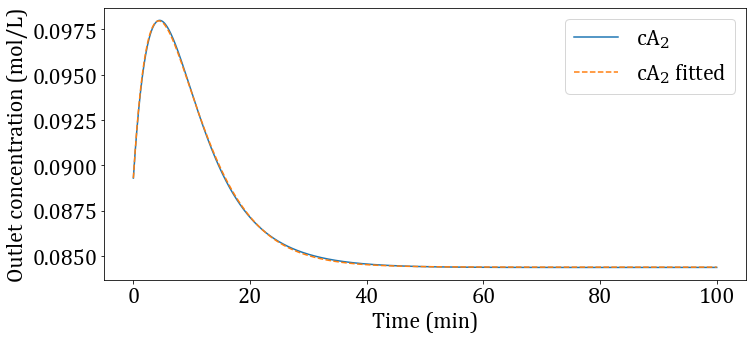

K: -0.0008933041100054032, τ: 5.197902097969803, β: 28.4709693869595, ζ: 1.014822543286416


In [253]:
K_10fit_so, τ_10fit_so, β_10fit_so, ζ_10fit_so = scipy.optimize.curve_fit(second_order_pole, t, cA2, [K_guess, τ_guess, β_guess, ζ_guess])[0]
cA2_10fit_so = second_order_pole(t, K_10fit_so, τ_10fit_so, β_10fit_so, ζ_10fit_so)

fig, axcA = plt.subplots(1,1,figsize = (23/2, 5))

T1,cA2,T2 = simulate()
#axT.plot(t,T1, label = 'T$_{1}$',linestyle = '--')
#axT.plot(t,T2, label = 'T$_{2}$')
#axT.legend()
#axT.set_ylabel('Temperature (K)')
axcA.plot(t,cA2, label = 'cA$_{2}$')
axcA.plot(t, cA2_10fit_so, linestyle='--', label='cA$_{2}$ fitted')
plt.xlabel('Time (min)')
axcA.set_ylabel('Outlet concentration (mol/L)')
plt.legend()
#plt.savefig('10_fit_so.svg')
plt.show()

print(f'K: {K_10fit_so}, τ: {τ_10fit_so}, β: {β_10fit_so}, ζ: {ζ_10fit_so}')

#### Calculation of PID controller parameters and simulation

In [259]:
# case D
τ_c = τ_10fit_so/3

Kc_pid = 2*ζ_10fit_so*τ_10fit_so/(τ_c + β_10fit_so)/K_10fit_so
τi_pid = 2*ζ_10fit_so*τ_10fit_so
τd_pid = τ_10fit_so/(2*ζ_10fit_so)

Kc_pid, τi_pid, τd_pid

(-391.01201781079396, 10.549896453631025, 2.5609906541575445)

In [260]:
M_d = 0.02*298.15
M_sp = 0.1*cA2_ss

def DV_Ti(t): #this is your disturbance variable 
    if t<0: 
        return 298.15
    elif (t >= 0):
        return 298.15 + M_d

def SP_cA2(t): # set point
    if (t < 0):
        return cA2_ss
    if (t >= 0):
        return cA2_ss

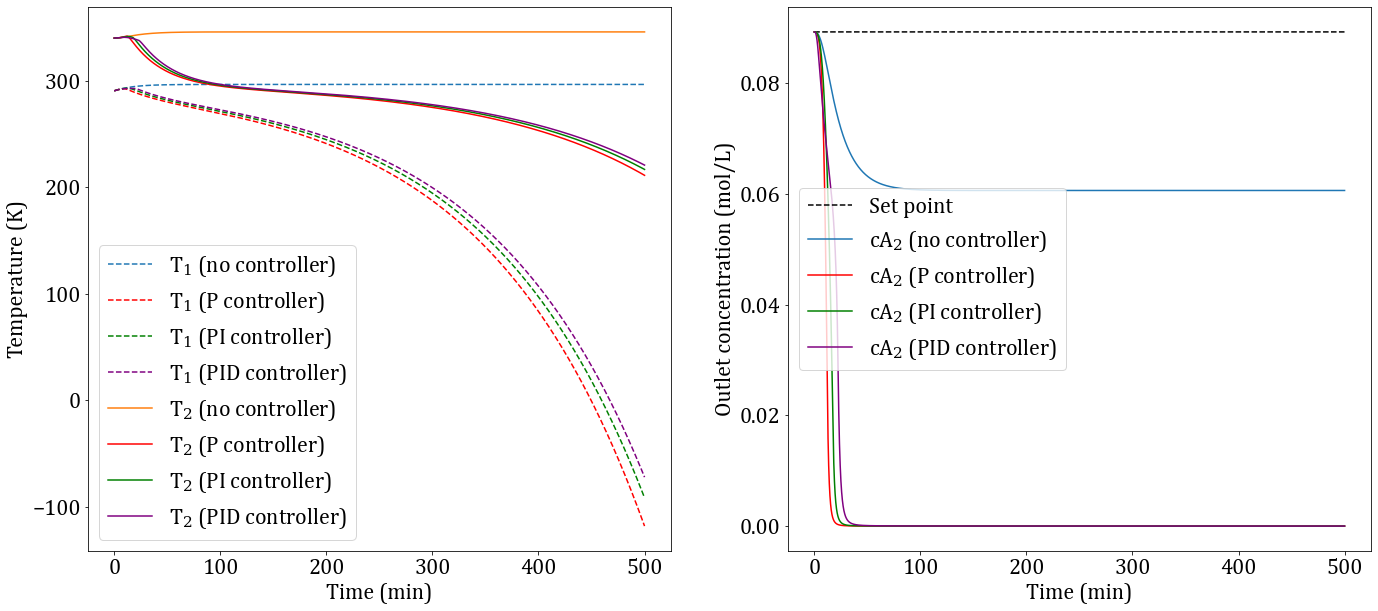

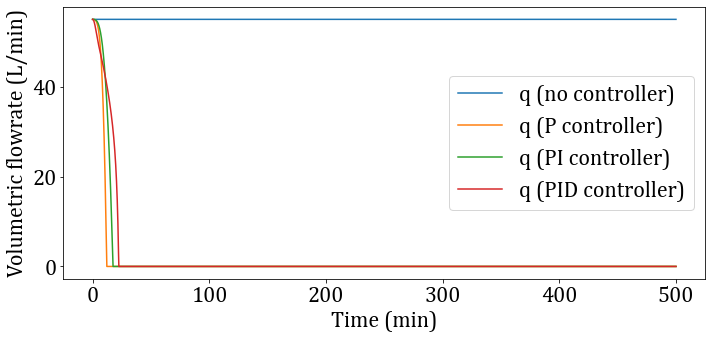

In [261]:
sim_closed_loop('2_sp_tc_imc.svg', '2_sp_q_imc.svg')

###  Manually tuned controller

#### Gain selection
Plotting the responses of the three controllers to varying controller gains to for manual controller gain selection. $\tau_{I}$ and $\tau_{D}$ from the IMC tuning was used.

In [264]:
def manual_tuned_p_controller(Kc_p_list):
    global Kc_p
    tspan = (0, 500)
    t = numpy.linspace(*tspan, int(5e4))
    initial = numpy.append(numpy.array(x0), numpy.array(55))
    fig, axcA = plt.subplots(1,1,figsize = (23/2, 10))
    axcA.set_xlabel('Time (min)')
    axcA.set_ylabel('Outlet concentration (mol/L)')
    axcA.plot(t, list(map(SP_cA2, t)), 'k', linestyle='--', label='Set point')
    
    for Kc_p in Kc_p_list:
        Kc_p = Kc_p
        T1_p, cA2_p, T2_p, q_p = euler_simulate_with_controller(t, initial, 'P') 
        
        # concentration
        axcA.plot(t,cA2_p, label = f'cA$_{2}$ (Kp = {round(Kc_p, 2)})')
    axcA.legend()
    #plt.savefig('P_controllers_gain.svg')
    plt.show()

def manual_tuned_pi_controller(Kc_pi_list):
    global Kc_pi
    tspan = (0, 500)
    t = numpy.linspace(*tspan, int(5e4))
    initial = numpy.append(numpy.array(x0), numpy.array(55))
    fig, axcA = plt.subplots(1,1,figsize = (23/2, 10))
    axcA.set_xlabel('Time (min)')
    axcA.set_ylabel('Outlet concentration (mol/L)')
    axcA.plot(t, list(map(SP_cA2, t)), 'k', linestyle='--', label='Set point')
    
    for Kc_pi in Kc_pi_list:
        Kc_pi = Kc_pi
        T1_p, cA2_p, T2_p, q_p = euler_simulate_with_controller(t, initial, 'PI') 
        
        # concentration
        axcA.plot(t,cA2_p, label = f'cA$_{2}$ (Kp = {round(Kc_pi, 2)})')
    axcA.legend(loc='right')
    #plt.savefig('PI_controllers_gain.svg')
    plt.show()
    
def manual_tuned_pid_controller(Kc_pid_list):
    global Kc_pid
    tspan = (0, 500)
    t = numpy.linspace(*tspan, int(5e4))
    initial = numpy.append(numpy.array(x0), numpy.array(55))
    fig, axcA = plt.subplots(1,1,figsize = (23/2, 10))
    axcA.set_xlabel('Time (min)')
    axcA.set_ylabel('Outlet concentration (mol/L)')
    axcA.plot(t, list(map(SP_cA2, t)), 'k', linestyle='--', label='Set point')
    
    for Kc_pid in Kc_pid_list:
        Kc_pid = Kc_pid
        T1_p, cA2_p, T2_p, q_p = euler_simulate_with_controller(t, initial, 'PID') 
        
        # concentration
        axcA.plot(t,cA2_p, label = f'cA$_{2}$ (Kp = {round(Kc_pid, 2)})')
    axcA.legend(loc='right')
    #plt.savefig('PID_controllers_gain.svg')
    plt.show()

In [265]:
M_d = 0.02*298.15
M_sp = 0.1*cA2_ss

def DV_Ti(t): #this is your disturbance variable 
    if t<0: 
        return 298.15
    elif (t >= 0):
        return 298.15 + M_d

def SP_cA2(t): # set point
    if (t < 0):
        return cA2_ss
    if (t >= 0):
        return cA2_ss

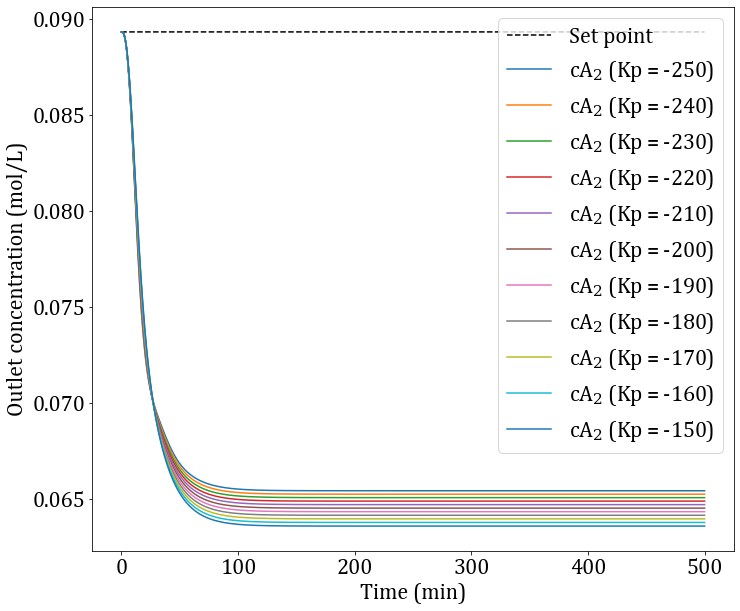

In [267]:
Kc_p_list = numpy.arange(-250, -140, 10)
manual_tuned_p_controller(Kc_p_list)

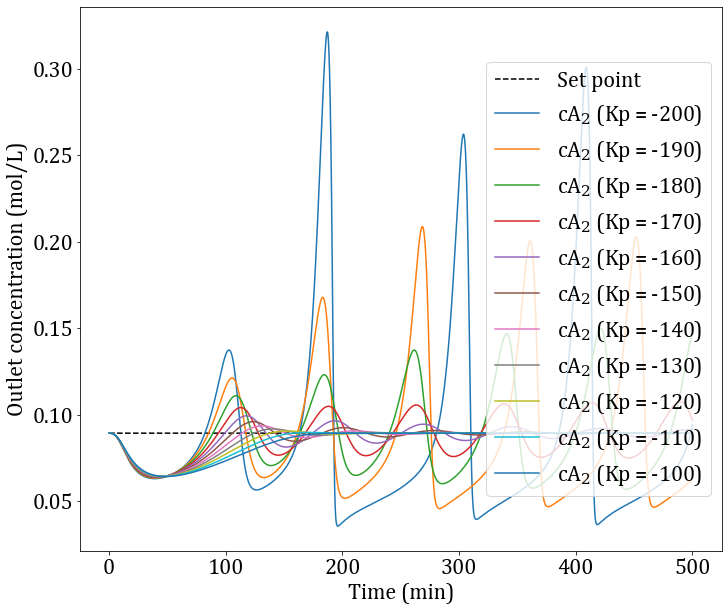

In [268]:
τi_pi = 10.55
Kc_pi_list = numpy.arange(-200, -90, 10)
manual_tuned_pi_controller(Kc_pi_list)

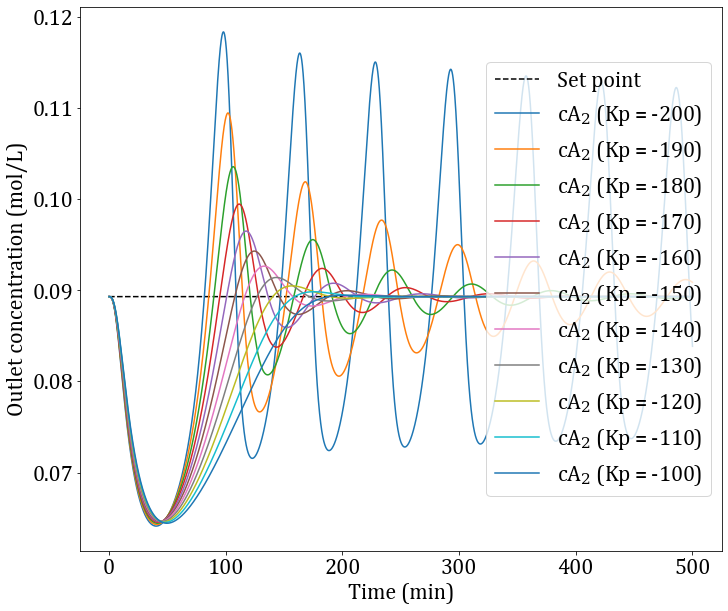

In [269]:
τi_pid = 10.55
τd_pid = 2.561
Kc_pid_list = numpy.arange(-200, -90, 10)
manual_tuned_pid_controller(Kc_pid_list)

#### Final response of manually tuned controllers

In [270]:
M_d = 0.02*298.15
M_sp = 0.1*cA2_ss

def DV_Ti(t): #this is your disturbance variable 
    if t<0: 
        return 298.15
    elif (t >= 0):
        return 298.15 + M_d

def SP_cA2(t): # set point
    if (t < 0):
        return cA2_ss
    if (t >= 0):
        return cA2_ss #+ M_sp

In [272]:
Kc_p = -330

Kc_pi = -130
τi_pi = 10.55

Kc_pid = -130 
τi_pid = 10.55  
τd_pid = 2.561 

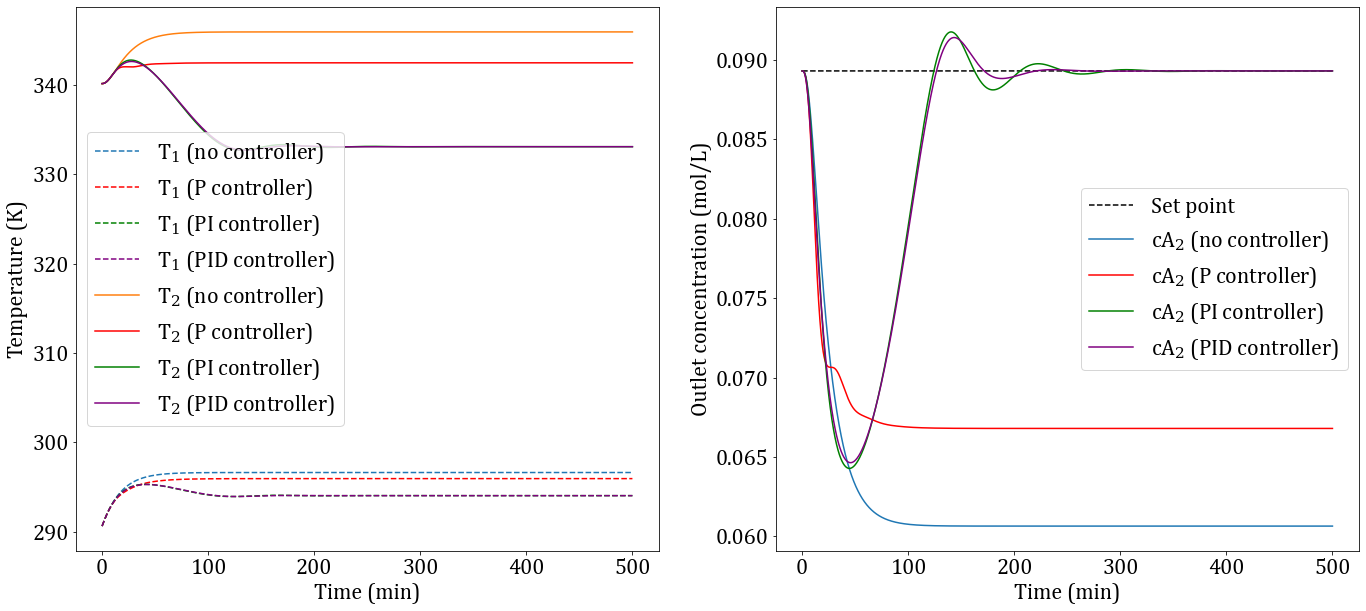

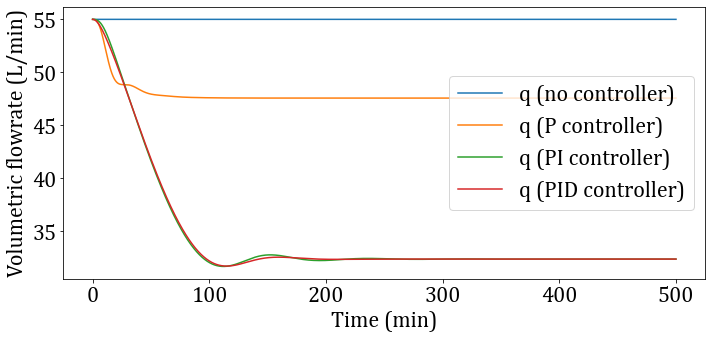

In [273]:
sim_closed_loop('manual_configured_controllers_tc_sc.svg', 'manual_configured_controllers_q_sc.svg')

## Noise
Investigating the effect of noise on the closed-loop system

In [274]:
M_d = 0.02*298.15
M_sp = 0.1*cA2_ss

def DV_Ti(t): #this is your disturbance variable 
    if t<0: 
        return 298.15
    elif (t >= 0):
        return 298.15 + M_d

def SP_cA2(t): # set point
    if (t < 0):
        return cA2_ss
    if (t >= 0):
        return cA2_ss 
    
# continous form
def q_controller(cont_id, dt, q, e_hist, ei, ei1):
    if (cont_id == None):
        p = 55
    elif (cont_id == 'P'):
        p = 55 + Kc_p*ei
    elif (cont_id == 'PI'):
        p = 55 + Kc_pi*(ei + 1/τi_pi*e_hist*dt)
    elif (cont_id == 'PID'):
        p = 55 + Kc_pid*(ei + 1/τi_pid*e_hist*dt + τd_pid*(ei - ei1)/dt)
        
    # saturation
    if (p < 0):
        p = 0
    if (p > 2*55):
        p = 2*55
    return p

def euler_simulate_with_controller_with_noise(tspan, initial, cont_id=None):
    dt = tspan[1]
    T1, cA2, T2, q = initial
    q = 55
    T1_list, cA2_list, T2_list, q_list = [T1], [cA2], [T2], [q]
    e_hist = 0
    ei = 0
    ei1 = 0
    for i, t in enumerate(tspan):
        if (i != 0):
            # noise
            cA2 += numpy.random.normal(0, 5e-5) # for noise through the entire system 
            
            # error and controller
            ei1 = ei
            ei = SP_cA2(t) - cA2 #+ numpy.random.normal(0, 5e-4) # for noise replicating an analyzer only
            if (q != 0) or (q != 2*55): # anti-reset windup
                e_hist += ei
            q = q_controller(cont_id, dt, q, e_hist, ei, ei1)
            
            # the remainder of the system
            cA1 = cA0
            k = k0*numpy.exp(-E_over_R/T2)

            dT1dt = 1/(V1*ρ*C)*(ρ*q*C*(DV_Ti(t) - T1) + UA*(T1 - T2))
            dcA2dt = q*(cA1 - cA2)/V - k*cA2
            dT2dt = 1/(V2*ρ*C)*(ρ*q*C*(T1 - T2) - Hr*V2*k*cA2 + UA*(T1 - T2)-UcAc*(T2-Tc))
            T1 = T1 + dT1dt*dt
            T2 = T2 + dT2dt*dt
            cA2 = cA2 + dcA2dt*dt

            T1_list.append(T1)
            T2_list.append(T2)
            cA2_list.append(cA2)
            q_list.append(q)   
    return T1_list, cA2_list, T2_list, q_list

def sim_closed_loop_with_noise(filename_tc, filename_q):
    tspan = (0, 500)
    t = numpy.linspace(*tspan, int(5e4))
    initial = numpy.append(numpy.array(x0), numpy.array(55))

    T1_p, cA2_p, T2_p, q_p = euler_simulate_with_controller_with_noise(t, initial, 'P')
    T1_pi, cA2_pi, T2_pi, q_pi = euler_simulate_with_controller_with_noise(t, initial, 'PI')
    T1_pid, cA2_pid, T2_pid, q_pid = euler_simulate_with_controller_with_noise(t, initial, 'PID')
    T1, cA2, T2, q = euler_simulate_with_controller_with_noise(t, initial)
    fig, [axT,axcA] = plt.subplots(1,2,figsize = (23, 10))

    # temperature
    axT.plot(t,T1, label = 'T$_{1}$ (no controller)',linestyle = '--')
    axT.plot(t,T1_p, 'r', label = 'T$_{1}$ (P controller)',linestyle = '--')
    axT.plot(t,T1_pi, 'g', label = 'T$_{1}$ (PI controller)',linestyle = '--')
    axT.plot(t,T1_pid, 'purple', label = 'T$_{1}$ (PID controller)',linestyle = '--')

    axT.plot(t,T2, label = 'T$_{2}$ (no controller)')
    axT.plot(t,T2_p, 'r', label = 'T$_{2}$ (P controller)')
    axT.plot(t,T2_pi, 'g', label = 'T$_{2}$ (PI controller)')
    axT.plot(t,T2_pid, 'purple', label = 'T$_{2}$ (PID controller)')

    axT.set_xlabel('Time (min)')
    axT.set_ylabel('Temperature (K)')
    axT.legend()

    # concentration
    axcA.plot(t, list(map(SP_cA2, t)), 'k', linestyle='--', label='Set point')
    axcA.plot(t,cA2, label = 'cA$_{2}$ (no controller)')
    axcA.plot(t,cA2_p, 'r', label = 'cA$_{2}$ (P controller)')
    axcA.plot(t,cA2_pi, 'g', label = 'cA$_{2}$ (PI controller)')
    axcA.plot(t,cA2_pid, 'purple', label = 'cA$_{2}$ (PID controller)')

    axcA.set_xlabel('Time (min)')
    axcA.set_ylabel('Outlet concentration (mol/L)')
    axcA.legend(loc='lower right')

    #plt.savefig(filename_tc)
    plt.show()
    
    fig, axQ = plt.subplots(1,1,figsize = (23/2, 5))

    # q
    axQ.plot(t, q_pid, label='q (PID controller)')
    axQ.plot(t, q, label='q (no controller)')
    axQ.plot(t, q_p, label='q (P controller)')
    axQ.plot(t, q_pi, label='q (PI controller)')


    axQ.set_xlabel('Time (min)')
    axQ.set_ylabel('Volumetric flowrate (L/min)')
    axQ.legend(loc='lower right')
    #plt.savefig(filename_q)

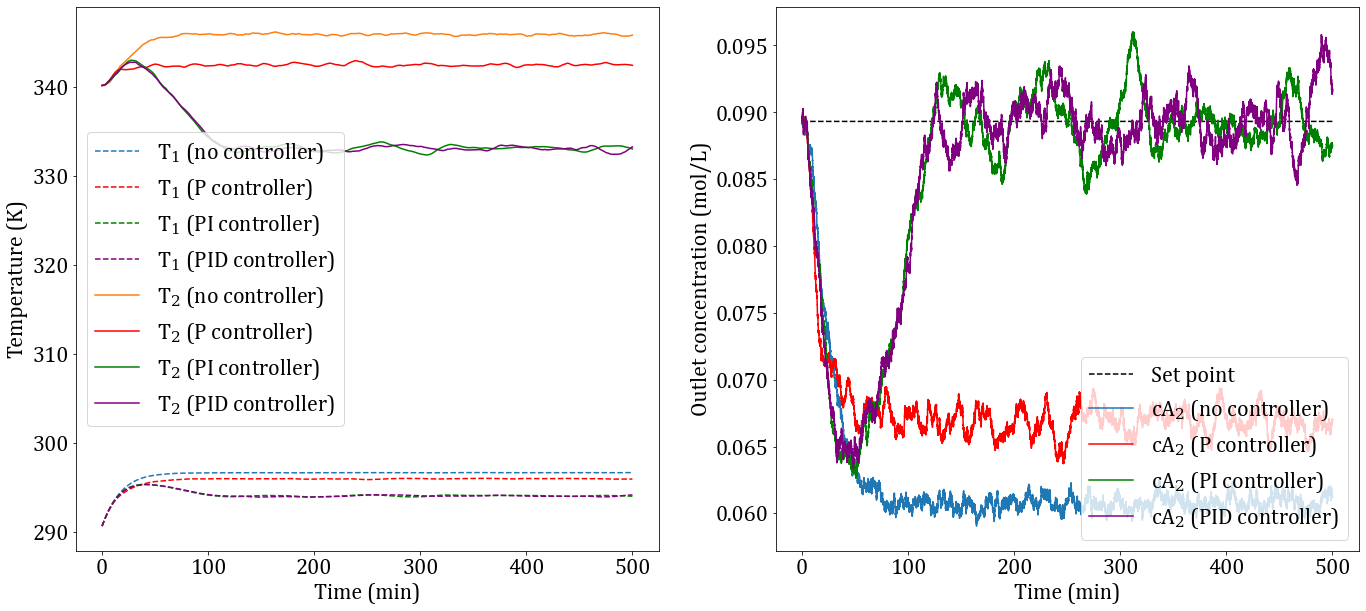

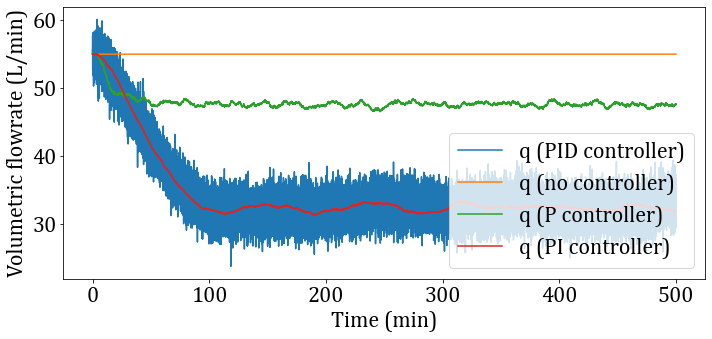

In [275]:
sim_closed_loop_with_noise('noise_tc_sc_measured_system.svg','noise_q_sc_measured_system.svg')

## Robustness and performance analysis
Responses for varying step disturbance and set point changes were simulated (both positive and negative).

## For varying step disturbances

In [276]:
#M_d_span = numpy.arange(0, 5+0.5, 0.5)[1:]/100*298.15 # positive step changes
M_d_span = numpy.arange(-3, 0, 0.5)/100*298.15 # negative step changes

### P controller

,Disturbance step change %,Offset %,Settling time
0,-3.0,856.423324,0.000000
1,-2.5,26.045164,79.841597
2,-2.0,257.849925,0.000000
3,-1.5,12.244160,0.000000
4,-1.0,17.579084,0.000000
5,-0.5,8.213144,0.000000


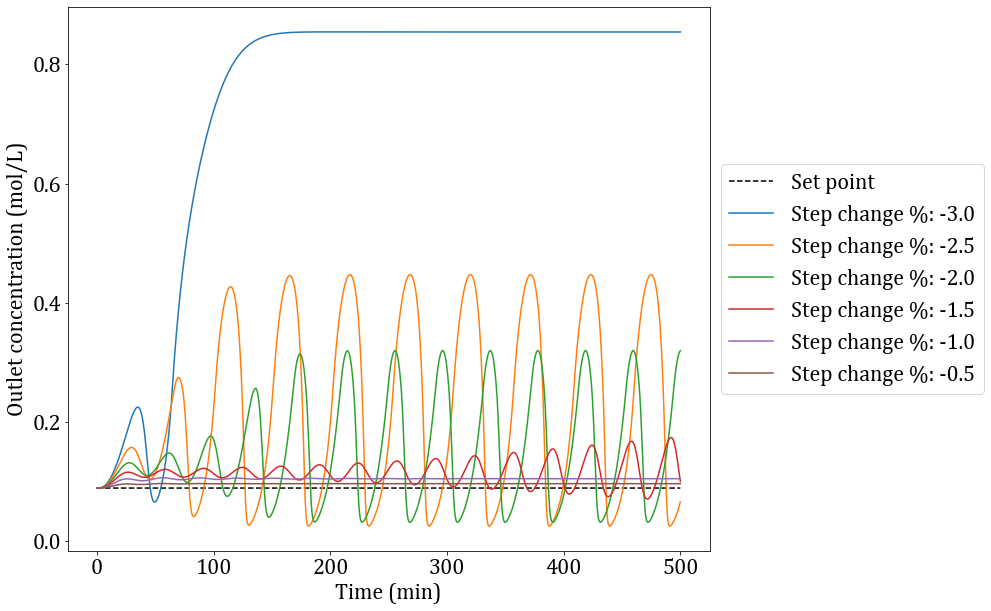

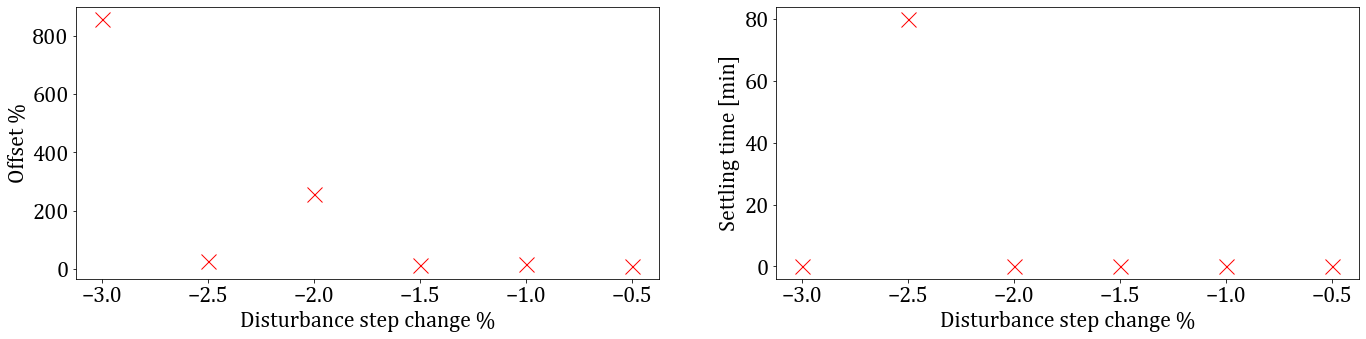

In [277]:
tspan = (0, 500)
t = numpy.linspace(*tspan, int(5e4))
initial = numpy.append(numpy.array(x0), numpy.array(55))
fig, axcA = plt.subplots(1,1,figsize = (23/2, 10))
axcA.plot(t, list(map(SP_cA2, t)), 'k', linestyle='--', label='Set point')
axcA.set_xlabel('Time (min)')
axcA.set_ylabel('Outlet concentration (mol/L)')

offsets = []
settlings = []
for M_d in M_d_span:
    def DV_Ti(t): #this is your disturbance variable 
        if t<0: 
            return 298.15
        elif (t >= 0):
            return 298.15 + M_d

    def SP_cA2(t): # set point
        if (t < 0):
            return cA2_ss
        if (t >= 0):
            return cA2_ss 

    T1, cA2, T2, q = euler_simulate_with_controller(t, initial, 'P')
    axcA.plot(t, cA2, label = f'Step change %: {round(M_d/298.15*100, 2)}')
        
    # Offset
    offsets.append(abs(cA2[-1] - SP_cA2(t[1]))/SP_cA2(t[1])*100)
    
    # Settling time
    settlings.append(t[cA2 <= 1.01*cA2[-1]][0])
        
axcA.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
#plt.savefig('pr_P_neg_dist.svg')
metrics = {'Disturbance step change %': M_d_span/298.15*100, 'Offset %': offsets, 'Settling time': settlings}

# metrics plots
fig, [ax_offset, ax_settling] = plt.subplots(1, 2, figsize=(23, 5))
ax_offset.plot(M_d_span/298.15*100, offsets, 'rx', markersize=15)
ax_offset.set_xlabel('Disturbance step change %')
ax_offset.set_ylabel('Offset %')
ax_settling.plot(M_d_span/298.15*100, settlings, 'rx', markersize=15)
ax_settling.set_xlabel('Disturbance step change %')
ax_settling.set_ylabel('Settling time [min]')
#plt.savefig('pr_metrics_P_neg_dist.svg')

metrics = pd.DataFrame(data=metrics)      
display(metrics)  

### PI and PID controller

,Disturbance step change %,Rise times,Overshoot %
0,-3.0,NaN,204.459976
1,-2.5,NaN,93.585412
2,-2.0,NaN,58.248121
3,-1.5,NaN,37.043412
4,-1.0,448.092962,21.795795
5,-0.5,218.026361,9.842881


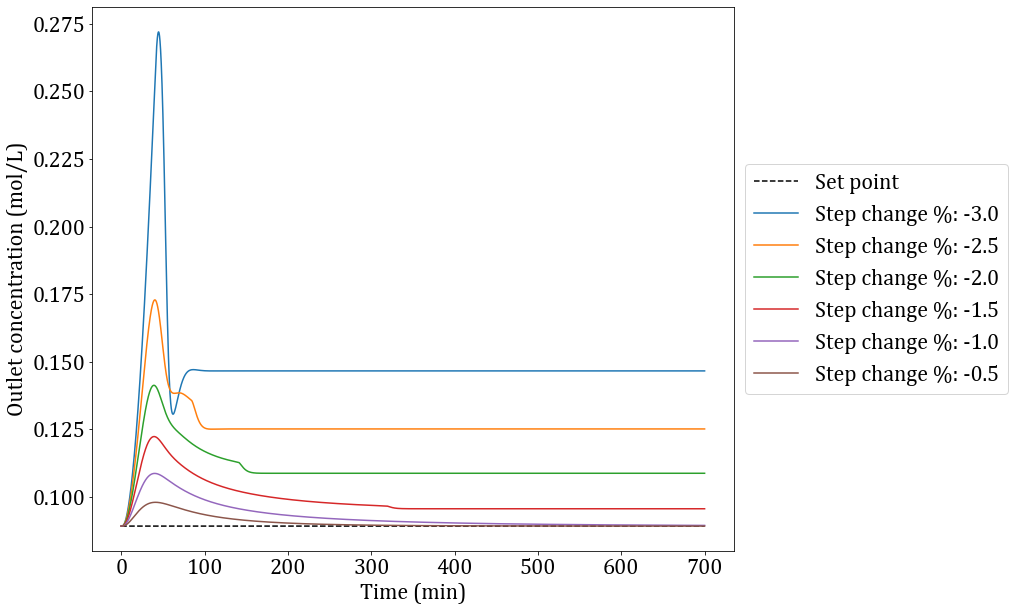

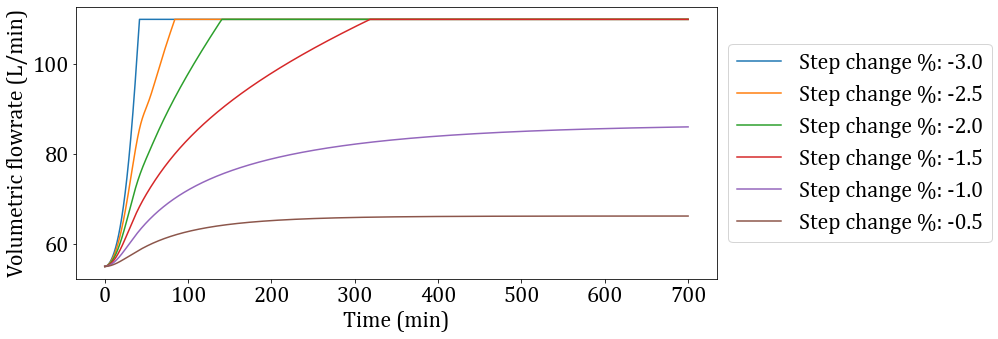

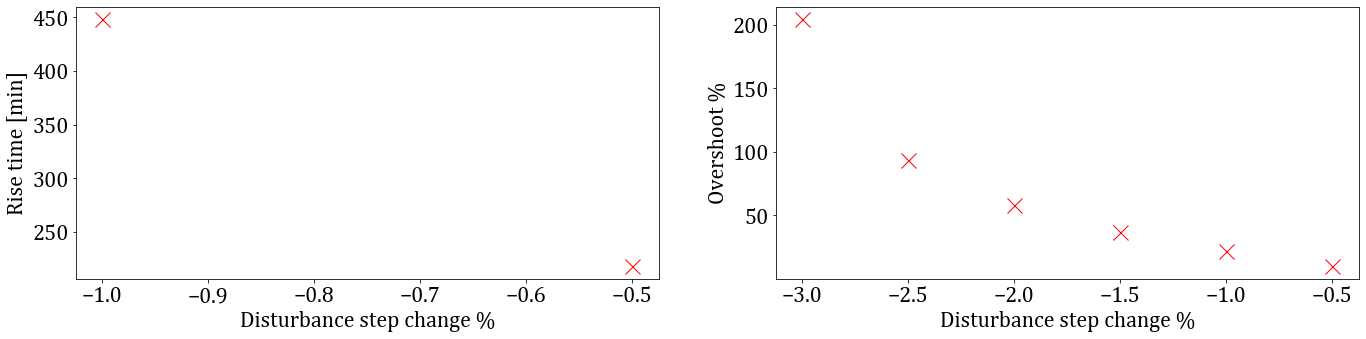

In [208]:
tspan = (0, 700)
t = numpy.linspace(*tspan, int(5e4))
initial = numpy.append(numpy.array(x0), numpy.array(55))
fig, axcA = plt.subplots(1,1,figsize = (23/2, 10))
fig2, axq = plt.subplots(1,1, figsize = (23/2, 5))
axcA.plot(t, list(map(SP_cA2, t)), 'k', linestyle='--', label='Set point')
axcA.set_xlabel('Time (min)')
axcA.set_ylabel('Outlet concentration (mol/L)')

axq.set_xlabel('Time (min)')
axq.set_ylabel('Volumetric flowrate (L/min)')

rise_times = []
overshoots = []
for M_d in M_d_span:
    def DV_Ti(t): #this is your disturbance variable 
        if t<0: 
            return 298.15
        elif (t >= 0):
            return 298.15 + M_d

    def SP_cA2(t): # set point
        if (t < 0):
            return cA2_ss
        if (t >= 0):
            return cA2_ss 

    T1, cA2, T2, q = euler_simulate_with_controller(t, initial, 'PID') # <--- Select controller by changing the parameter here
    axcA.plot(t, cA2, label=f'Step change %: {round(M_d/298.15*100, 2)}')
    axq.plot(t, q, label=f'Step change %: {round(M_d/298.15*100, 2)}')    
    
    # rise time
    try:
        #rise_times.append(t[1000:][cA2[1000:] > SP_cA2(t[1])][0]) # first time to reach steady state
        rise_times.append(t[1000:][cA2[1000:] < 1.01*SP_cA2(t[1])][0]) # first time to reach steady state (from the opposite direction, for negative step changes)
    except:
        rise_times.append(None)
    
    # overshoot
    overshoot = (max(cA2[:14000]) - SP_cA2(t[1]))/SP_cA2(t[1])*100
    if (overshoot == 0):
        overshoots.append(None)
    else:
        overshoots.append(overshoot)
    
axq.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
axcA.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
fig.savefig('pr_PID_neg_dist.svg')
fig2.savefig('pr_PID_neg_dist_q.svg')
metrics = {'Disturbance step change %': M_d_span/298.15*100, 'Rise times': rise_times, 'Overshoot %': overshoots}

# metrics plots
fig, [ax_rise, ax_over] = plt.subplots(1, 2, figsize=(23, 5))
ax_rise.plot(M_d_span[2:]/298.15*100, rise_times[2:], 'rx', markersize=15)
ax_rise.set_xlabel('Disturbance step change %')
ax_rise.set_ylabel('Rise time [min]')

ax_over.plot(M_d_span/298.15*100, overshoots, 'rx', markersize=15)
ax_over.set_xlabel('Disturbance step change %')
ax_over.set_ylabel('Overshoot %')
#plt.savefig('pr_metrics_PID_pos_dist.svg')

metrics = pd.DataFrame(data=metrics)      
display(metrics)      

## For varying set point changes

In [278]:
#M_SP_span = numpy.arange(0, 10+1, 1)[1:]/100*cA2_ss
M_SP_span  = numpy.arange(-3, 0, 0.5)/100*cA2_ss

### P controller

,Set-point step change %,Offset %
0,-3.0,2.328386
1,-2.5,1.929184
2,-2.0,1.534526
3,-1.5,1.144345
4,-1.0,0.758574
5,-0.5,0.377147


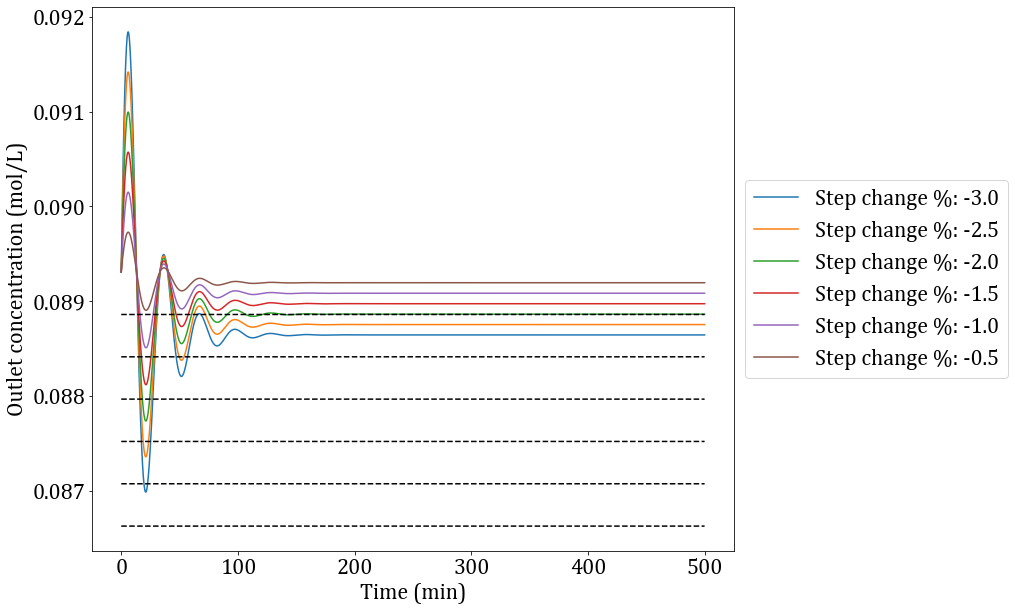

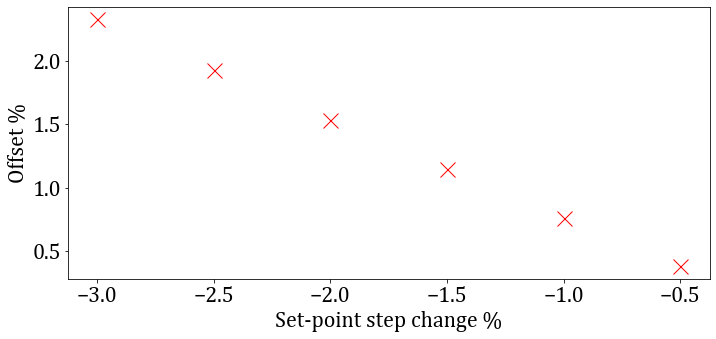

In [280]:
tspan = (0, 500)
t = numpy.linspace(*tspan, int(5e4))
initial = numpy.append(numpy.array(x0), numpy.array(55))
fig, axcA = plt.subplots(1,1,figsize = (23/2, 10))
axcA.set_xlabel('Time (min)')
axcA.set_ylabel('Outlet concentration (mol/L)')

offsets = []
for M_SP in M_SP_span:
    def DV_Ti(t): #this is your disturbance variable 
        if t<0: 
            return 298.15
        elif (t >= 0):
            return 298.15

    def SP_cA2(t): # set point
        if (t < 0):
            return cA2_ss
        if (t >= 0):
            return cA2_ss + M_SP

    T1, cA2, T2, q = euler_simulate_with_controller(t, initial, 'P')
    axcA.plot(t, list(map(SP_cA2, t)), 'k', linestyle='--')
    axcA.plot(t, cA2, label = f'Step change %: {round(M_SP/cA2_ss*100, 2)}')
        
    # Offset
    offsets.append(abs(cA2[-1] - SP_cA2(t[1]))/SP_cA2(t[1])*100)
      
axcA.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
#plt.savefig('pr_P_neg_sp.svg')
metrics = {'Set-point step change %': M_SP_span/cA2_ss*100, 'Offset %': offsets}

# metrics plots
fig, ax_offset = plt.subplots(1, 1, figsize=(23/2, 5))
ax_offset.plot(M_SP_span/cA2_ss*100, offsets, 'rx', markersize=15)
ax_offset.set_xlabel('Set-point step change %')
ax_offset.set_ylabel('Offset %')
#plt.savefig('pr_metrics_P_neg_sp.svg')

metrics = pd.DataFrame(data=metrics)      
display(metrics)  

### PI and PID controller

,Disturbance step change %,Rise times,Overshoot %
0,-3.0,86.339727,4.281521
1,-2.5,74.915498,3.685015
2,-2.0,61.741235,2.933010
3,-1.5,45.766915,2.188620
4,-1.0,24.052481,1.451730
5,-0.5,14.000280,0.722227


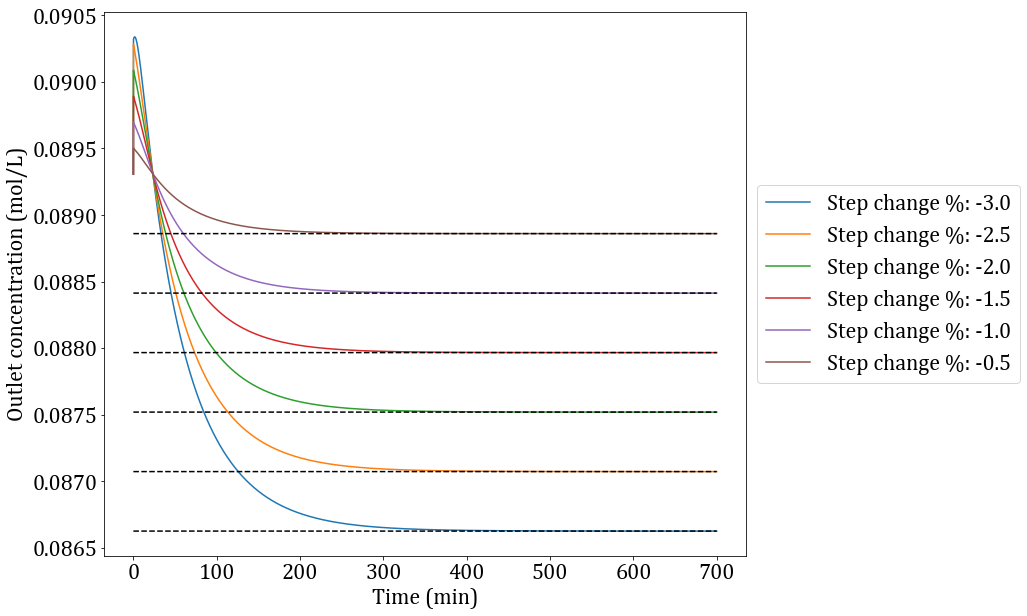

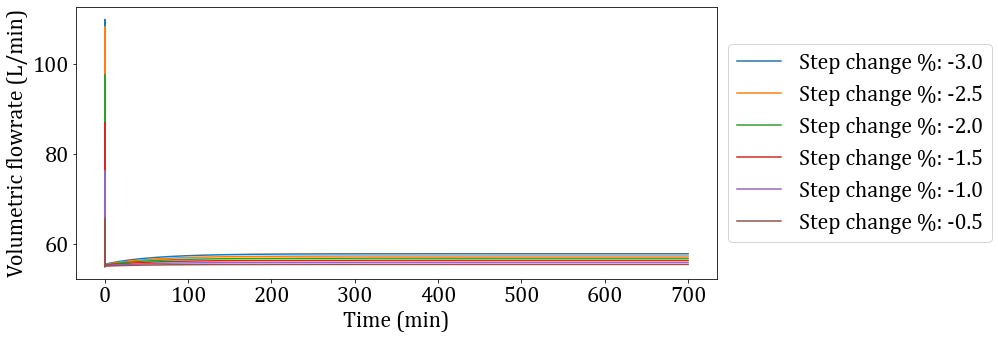

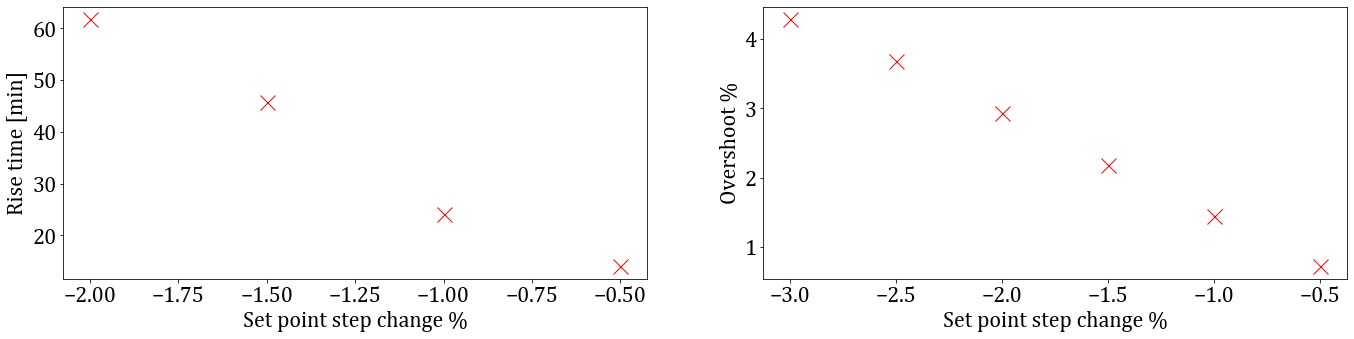

In [283]:
tspan = (0, 700)
t = numpy.linspace(*tspan, int(5e4))
initial = numpy.append(numpy.array(x0), numpy.array(55))
fig, axcA = plt.subplots(1,1,figsize = (23/2, 10))
fig2, axq = plt.subplots(1,1, figsize = (23/2, 5))
axcA.set_xlabel('Time (min)')
axcA.set_ylabel('Outlet concentration (mol/L)')

axq.set_xlabel('Time (min)')
axq.set_ylabel('Volumetric flowrate (L/min)')

rise_times = []
overshoots = []
for M_SP in M_SP_span:
    def DV_Ti(t): #this is your disturbance variable 
        if t<0: 
            return 298.15
        elif (t >= 0):
            return 298.15

    def SP_cA2(t): # set point
        if (t < 0):
            return cA2_ss
        if (t >= 0):
            return cA2_ss + M_SP

    T1, cA2, T2, q = euler_simulate_with_controller(t, initial, 'PID') # <--- Select controller by changing the parameter here
    axcA.plot(t, cA2, label=f'Step change %: {round(M_SP/cA2_ss*100, 2)}')
    axq.plot(t, q, label=f'Step change %: {round(M_SP/cA2_ss*100, 2)}')  
    axcA.plot(t, list(map(SP_cA2, t)), 'k', linestyle='--')
    
    # rise time
    try:
        #rise_times.append(t[1000:][cA2[1000:] > SP_cA2(t[1])][0]) # first time to reach steady state
        rise_times.append(t[1000:][cA2[1000:] < 1.01*SP_cA2(t[1])][0]) # first time to reach steady state (from the opposite direction, for negative step changes)
    except:
        rise_times.append(None)
    
    # overshoot
    overshoot = (max(cA2[:14000]) - SP_cA2(t[1]))/SP_cA2(t[1])*100
    if (overshoot == 0):
        overshoots.append(None)
    else:
        overshoots.append(overshoot)
    
axq.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
axcA.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
#fig.savefig('pr_PI_pos_sp.svg')
#fig2.savefig('pr_PI_pos_sp_q.svg')
metrics = {'Disturbance step change %': M_SP_span/cA2_ss*100, 'Rise times': rise_times, 'Overshoot %': overshoots}

# metrics plots
fig, [ax_rise, ax_over] = plt.subplots(1, 2, figsize=(23, 5))
ax_rise.plot(M_SP_span[2:]/cA2_ss*100, rise_times[2:], 'rx', markersize=15)
ax_rise.set_xlabel('Set point step change %')
ax_rise.set_ylabel('Rise time [min]')

ax_over.plot(M_SP_span/cA2_ss*100, overshoots, 'rx', markersize=15)
ax_over.set_xlabel('Set point step change %')
ax_over.set_ylabel('Overshoot %')
#plt.savefig('pr_metrics_PID_pos_dist.svg')

metrics = pd.DataFrame(data=metrics)      
display(metrics)   